In [38]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from random import shuffle
import csv

In [3]:
cats = []
dogs = []
for filename in glob.glob('cats/*.JPEG'):
    im=cv2.imread(filename,0)
    cats.append(im)
for filename in glob.glob('dogs/*.JPEG'):
    im=cv2.imread(filename,0)
    dogs.append(im)

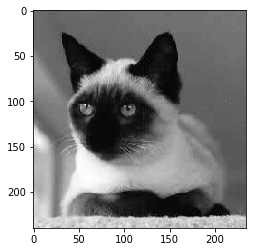

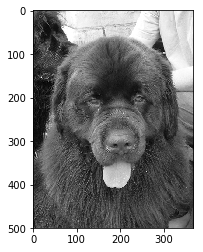

In [4]:
## Display one example image from the lists
plt.figure()
plt.imshow(cats[0],'gray')
plt.figure()
plt.imshow(dogs[0],'gray')

In [5]:
sift = cv2.xfeatures2d.SIFT_create()
_,cat0_descriptor = sift.detectAndCompute(cats[0],None)
print(cat0_descriptor.shape)
# In this image there are 154 descriptors, each descriptor is a
# 128 element row vector.


(154, 128)


In [11]:
shuffle(cats)
shuffle(dogs)
print(len(cats))
print(len(dogs))
cats_train = cats[0:700]
cats_test = cats[700:]
dogs_train = dogs[0:1200]
dogs_test = dogs[1200:]

977
1714


In [12]:
all_cat_desc = np.zeros((1,128)) #initialize a place to store descripotrs
i = 0
for img in cats_train:
    _,des = sift.detectAndCompute(img,None) # Compute the descriptor of each image
    all_cat_desc = np.vstack((all_cat_desc,des))    #stack the descriptors of current image to all descriptors
    if i%100 == 0:
        print('Processing the {}th image'.format(i))
    i = i+1
all_cat_desc = np.delete(all_cat_desc,0,0) # delete the first row of zeros

Processing the 0th image
Processing the 100th image
Processing the 200th image
Processing the 300th image
Processing the 400th image
Processing the 500th image
Processing the 600th image


In [13]:
all_dog_desc = np.zeros((1,128)) #initialize a place to store descripotrs
i = 0
for img in dogs_train:
    _,des = sift.detectAndCompute(img,None) # Compute the descriptor of each image
    all_dog_desc = np.vstack((all_dog_desc,des))    #stack the descriptors of current image to all descriptors
    if i%100 == 0:
        print('Processing the {}th image'.format(i))
    i = i+1
all_dog_desc = np.delete(all_dog_desc,0,0) # delete the first row of zeros

Processing the 0th image
Processing the 100th image
Processing the 200th image
Processing the 300th image
Processing the 400th image
Processing the 500th image
Processing the 600th image
Processing the 700th image
Processing the 800th image
Processing the 900th image
Processing the 1000th image
Processing the 1100th image


In [14]:
print(all_cat_desc.shape)
print(all_dog_desc.shape)

(647629, 128)
(1029240, 128)


In [16]:
all_desc = np.vstack((all_cat_desc,all_dog_desc))
np.random.shuffle(all_desc) #shuffle the descriptors
X_desc = all_desc
print(X_desc.shape)
batch_size = 200000
kmeans = MiniBatchKMeans(n_clusters=200,random_state=0,batch_size=batch_size)
# can try different number of clusters

(1676869, 128)


In [17]:
for j in range(0,X_desc.shape[0],batch_size):
    print('Processing batch with the {}th descriptor'.format(j))
    batch = X_desc[j:j+batch_size,:]    #get a batch from X
    kmeans = kmeans.partial_fit(batch)  #partial fit with one batch

Processing batch with the 0th descriptor
Processing batch with the 200000th descriptor
Processing batch with the 400000th descriptor
Processing batch with the 600000th descriptor
Processing batch with the 800000th descriptor
Processing batch with the 1000000th descriptor
Processing batch with the 1200000th descriptor
Processing batch with the 1400000th descriptor
Processing batch with the 1600000th descriptor


In [18]:
print(kmeans.cluster_centers_)

[[56.99161512 44.03243986 15.66584192 ... 39.94158076 12.74061856
   8.57237113]
 [26.52452647 27.24696455 50.58025741 ... 17.92241379 28.87615347
  34.61947547]
 [51.53832175 51.68433993 24.77284874 ... 23.01507215  7.006093
   7.64585783]
 ...
 [63.10150922 24.77607602  7.37909447 ... 10.12677473  5.68373393
  24.17193963]
 [ 9.37549965 10.77404185 13.40171644 ...  9.97484129  8.0710087
  15.32659299]
 [24.50583829 30.42035691 33.3576779  ... 11.59484468 13.02103988
  22.49195858]]


(200,)


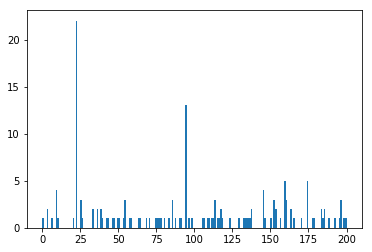

In [19]:
desc_quant = kmeans.predict(cat0_descriptor)
plt.figure()
h = plt.hist(desc_quant,bins = np.arange(0,201))
print(h[0].shape)

In [22]:
X_cat_train = np.zeros((1,200))    #initialize the data matrix
i = 0
for img in cats_train:
    _,des = sift.detectAndCompute(img,None)   #Compute the descriptor again
    desc_quant = kmeans.predict(des)     #find out which cluster the descriptor belongs to
    h = np.histogram(desc_quant,bins = np.arange(0,201))[0].reshape(1,h[0].shape[0])  #count the number of occurences of each descriptor
    X_cat_train = np.vstack((X_cat_train,h))  #put into the data matrix
    if i%100 == 0:
        print('Processing the {}th image'.format(i))
    i = i+1
X_cat_train = np.delete(X_cat_train,0,0)

Processing the 0th image
Processing the 100th image
Processing the 200th image
Processing the 300th image
Processing the 400th image
Processing the 500th image
Processing the 600th image


In [29]:
def createHist(img_list):
    _,des = sift.detectAndCompute(img_list[0],None)   #Compute the descriptor
    desc_quant = kmeans.predict(des)     #find out which cluster the descriptor belongs to
    hist,_ = np.histogram(desc_quant,bins = np.arange(0,201))  #count the number of occurences of each descriptor
    out = hist.reshape(1,hist.shape[0]) 
    for img in img_list[1:]:
        _,des = sift.detectAndCompute(img,None)   #Compute the descriptor 
        desc_quant = kmeans.predict(des)     #find out which cluster the descriptor belongs to
        h,_ = np.histogram(desc_quant,bins = np.arange(0,201))  #count the number of occurences of each descriptor
        h = h.reshape(1,h.shape[0]) 
        out = np.vstack((out,h))  #put into the data matrix
    return out

In [31]:
X_cat_test = createHist(cats_test)
X_cat_train = createHist(cats_train)
X_dog_train = createHist(dogs_train)
X_dog_test = createHist(dogs_test)

In [32]:
print(X_cat_train.shape)
print(X_cat_test.shape)
print(X_dog_train.shape)
print(X_dog_test.shape)

(700, 200)
(277, 200)
(1200, 200)
(514, 200)


In [44]:
Y_cat_train = np.zeros((X_cat_train.shape[0],1))
Y_cat_test = np.zeros((X_cat_test.shape[0],1))
Y_dog_train = np.zeros((X_dog_train.shape[0],1)) == 0
Y_dog_test = np.zeros((X_dog_test.shape[0],1)) ==0
XY_cat_train = np.hstack((X_cat_train,Y_cat_train))
XY_cat_test = np.hstack((X_cat_test,Y_cat_test))
XY_dog_train = np.hstack((X_dog_train,Y_dog_train))
XY_dog_test = np.hstack((X_dog_test,Y_dog_test))

In [45]:
with open('train_data.csv',mode='w') as dataFile:
    dataWriter = csv.writer(dataFile, delimiter = ',')
    dataToWrite = np.vstack((XY_cat_train,XY_dog_train))
    for row in dataToWrite:
        dataWriter.writerow(row)

In [46]:
with open('test_data.csv',mode='w') as dataFile:
    dataWriter = csv.writer(dataFile, delimiter = ',')
    dataToWrite = np.vstack((XY_cat_test,XY_dog_test))
    for row in dataToWrite:
        dataWriter.writerow(row)